In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import os
import textwrap
from io import StringIO
from tabulate import tabulate

In [5]:
def Save_Genreal_Report(corr_matrix, dup, head, tail, des, null, info, shape):
   
     try:
        folder_path = input("Enter the full path or name of the folder to save the report and heatmap: ").strip()
        os.makedirs(folder_path, exist_ok=True)
        report = os.path.join(folder_path, "report.txt")
        heatmap_file = os.path.join(folder_path, "correlation_heatmap.png")
       

        rows, cols = corr_matrix.shape
        max_label_length = max(len(label) for label in corr_matrix.columns)

        fig_width = max(8, cols * 0.5, max_label_length * 0.5)
        fig_height = max(6, rows * 0.5)

        plt.figure(figsize=(fig_width, fig_height))
        plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
        plt.colorbar()
        plt.xticks(np.arange(cols), corr_matrix.columns, rotation=45, ha="right", fontsize=12)
        plt.yticks(np.arange(rows), corr_matrix.columns, rotation=0, fontsize=12)
        plt.title('Correlation Matrix Heatmap', fontsize=14)
        plt.tight_layout()
        plt.savefig(heatmap_file)  
        plt.close()
        with open(report, 'w') as f:
            f.write("GENERAL ANALYSIS OF THE DATAFRAME\n")
            f.write("*" * 50 + "\n\n")
            f.write("-" * 50 + "\n")
            f.write(f"Shape of DataFrame: {shape}\n")
            f.write("-" * 50 + "\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Column Information:\n")
            f.write("-" * 50 + "\n")
            f.write(info + "\n") 
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Missing Values in Each Column:\n")
            f.write("-" * 50 + "\n")
            f.write(str(null) + "\n")
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Descriptive Statistics (Numerical):\n")
            f.write("-" * 50 + "\n")
            f.write(str(des) + "\n")
            # f.write(tabulate(des, headers='keys', tablefmt='psql'))
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("First 5 Rows of the DataFrame:\n")
            f.write("-" * 50 + "\n")
            f.write(str(head) + "\n")
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Last 5 Rows of the DataFrame:\n")
            f.write("-" * 50 + "\n")
            f.write(str(tail) + "\n")
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write(f"Number of Duplicate Rows: {dup}\n")
            f.write("-" * 50 + "\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Correlation Matrix (Numerical Columns):\n")
            f.write("-" * 50 + "\n")
            f.write(str(corr_matrix) + "\n")
            f.write("\n\n")
        
        print(f"Report successfully saved as '{report}'.")
     except Exception as e:
        print(f"Error: {e}")

    

In [8]:

def General_Analysis(df):
    print("\n" + "=" * 60)
    print("GENERAL ANALYSIS OF THE DATAFRAME".center(60))
    print("=" * 60 + "\n")
    
    pd.options.display.float_format = '{:,.2f}'.format
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)
    shape = df.shape
    print("-" * 60)
    print(f"Shape of DataFrame: {shape}")
    print("-" * 60 + "\n")
    print("COLUMN INFORMATION".center(60, "-"))
    buffer = StringIO()
    df.info(buf=buffer)
    info = buffer.getvalue()
    print(info)
    print("\n")
    print("MISSING VALUES IN EACH COLUMN".center(60, "-"))
    null_values = df.isnull().sum()
    print(null_values)
    print("\n")
    numdf = df.select_dtypes(include=['number'])
    print("DESCRIPTIVE STATISTICS (NUMERICAL)".center(60, "-"))
    des = numdf.describe()
    print(tabulate(des, headers='keys', tablefmt='psql'))
    print("\n")
    print("FIRST 5 ROWS OF THE DATAFRAME".center(60, "-"))
    head = df.head()
    print(tabulate(head, headers='keys', tablefmt='psql'))
    print("\n")
    print("LAST 5 ROWS OF THE DATAFRAME".center(60, "-"))
    tail = df.tail()
    print(tabulate(tail, headers='keys', tablefmt='psql'))
    print("\n")
    print("DUPLICATE ROWS".center(60, "-"))
    dup = df.duplicated().sum()
    print(f"Number of Duplicate Rows: {dup}")
    print("\n")
    print("CORRELATION MATRIX (NUMERICAL COLUMNS)".center(60, "-"))
    corr_matrix = numdf.corr()
    print(tabulate(corr_matrix, headers='keys', tablefmt='psql'))
    print("\n")
    rows, cols = corr_matrix.shape
    max_label_length = max(len(label) for label in corr_matrix.columns)
    fig_width = max(8, cols * 0.5, max_label_length * 0.5)
    fig_height = max(6, rows * 0.5)
    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(cols), corr_matrix.columns, rotation=45, ha="right", fontsize=12)
    plt.yticks(np.arange(rows), corr_matrix.columns, rotation=0, fontsize=12)
    plt.title('Correlation Matrix Heatmap', fontsize=14)
    plt.tight_layout()
    plt.show()

    save = input('Save General Report? (Y/N): ')
    if save.lower()=="y":
        Save_Genreal_Report(corr_matrix, dup, head, tail, des, null_values, info, shape)



 
    


In [14]:
def Custom_Analysis(df, col1, col2, num):
    col_names = {col.lower(): col for col in df.columns}
    col1_actual = col_names.get(col1.lower())
    col2_actual = col_names.get(col2.lower())
    if not col1_actual or not col2_actual:
        print(f"❌ Error: One or both columns '{col1}' or '{col2}' not found in DataFrame.")
        return
    column1_data = df[col1_actual]
    column2_data = df[col2_actual]
    print(f"Data for {col1_actual}:\n", column1_data.head(), "\n")
    print(f"Data for {col2_actual}:\n", column2_data.head(), "\n")
    


    print("=============================== Preview ================================")
    print(f"Data for {col1_actual}:\n", tabulate(column1_data.head(), headers='keys', tablefmt='psql'), "\n")
    print(f"Data for {col2_actual}:\n", tabulate(column2_data.head(), headers='keys', tablefmt='psql'), "\n")
    print(f"================================ Summary Statistics for {col1_actual} ======================================")
    print(column1_data.describe(), "\n")
    
    print(f"====================================== Summary Statistics for {col2_actual} ========================================")
    print(column2_data.describe(), "\n")
    correlation = column1_data.corr(column2_data)
    print(f"Correlation between {col1_actual} and {col2_actual}: {correlation}\n")
    null_count_col1 = column1_data.isnull().sum()
    empty_count_col1 = (column1_data.eq('')).sum()
    null_count_col2 = column2_data.isnull().sum()
    empty_count_col2 = (column2_data.eq('')).sum()
    
    print(f"Null values in {col1_actual}: {null_count_col1}")
    print(f"Empty values in {col1_actual}: {empty_count_col1}\n")
    
    print(f"Null values in {col2_actual}: {null_count_col2}")
    print(f"Empty values in {col2_actual}: {empty_count_col2}\n")
    plt.scatter(column1_data, column2_data)
    plt.xlabel(col1_actual)
    plt.ylabel(col2_actual)
    plt.title(f"Scatter Plot: {col1_actual} vs {col2_actual}")
    plt.show()
    plt.plot(column1_data, column2_data, marker='o', linestyle='-')
    plt.xlabel(col1_actual)
    plt.ylabel(col2_actual)
    plt.title(f"Line Plot: {col1_actual} vs {col2_actual}")
    plt.show()
    plt.hist(column1_data, alpha=0.5, label=col1_actual)
    plt.hist(column2_data, alpha=0.5, label=col2_actual)
    plt.legend()
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram: {col1_actual} and {col2_actual}")
    plt.show()
    df[[col1_actual, col2_actual]].boxplot()
    plt.title(f"Box Plot: {col1_actual} and {col2_actual}")
    plt.show()
        

        


In [10]:
def Analyze_Data(df):
    b=True
    while(b):
        print("1. General Analysis")
        print("2. Custom Analysis")
        print("3. Return")
        choice=input("Enter Choice: ").strip()
        if(choice=="1"):
           General_Analysis(df)
        elif(choice=="2"):
            b1=True
            while(b1):
                print("1. Analyze Two Numeric Columns")
                print("2. Analyze One Numeric and One String")
                print("3. Analyze One Numeric Column")
                print("4. Return")
                choice=input("Enter Choice: ").strip()
                if(choice=="1"):
                  col1=input('Enter 1st Numeric Column')
                  col2=input('Enter 2nd Numeric Column')
                  Custom_Analysis(df, col1, col2, 1)
                  
                elif(choice=="2"):
                    col1=input('Enter 1st Numeric Column')
                    col2=input('Enter 2nd String Column')
                    Custom_Analysis(df, col1, col2, 2)
                elif(choice=="3"):
                  col1=input('Enter 1st Numeric Column')
                  Custom_Analysis(df, col1, col2, 3)
                elif (choice=="4"):
                   b1=False
                else:
                  print("Please Enter Valid Choice !")
        elif(choice=="3"):
          # print("Exiting Program...")
          b=False
        else:
          print("Please Enter Valid Choice !")

In [11]:
def Load_Data():
    b=True
    while(b):
        print("1. Analyze CSV File")
        print("2. Analyze Parquet File")
        print("3. Analyze Excel File")
        print("4. Return")
        choice=input("Enter Choice: ").strip()
        if(choice=="1"):
          path = input("Enter File Path of CSV File: ")
          try:
              df = pd.read_csv(path, encoding='unicode_escape')
              Analyze_Data(df)
          except (FileNotFoundError, Exception) as e:
              print(f"Error: {e}")
              print("CSV File not found. Try again !")
               
        elif(choice=="2"):
              path = input("Enter File Path of Parquet File: ")
              try:
                  df = pd.read_parquet(path)
                  Analyze_Data(df)
              except (FileNotFoundError, Exception) as e:
                  print(f"Error: {e}")
                  print("Parquet File not found. Try again !")
        elif(choice=="3"):
              path = input("Enter File Path of Excel File: ")
              try:
                  df = pd.read_excel(path)
                  Analyze_Data(df)
              except (FileNotFoundError, Exception) as e:
                  print(f"Error: {e}")
                  print("Excel File not found. Try again !")
        elif(choice=="4"):
          # print("Exiting Program...")
          b=False
        else:
          print("Please Enter Valid Choice !")


In [15]:
def Edit_Data():
    b = True
    while b:
        print("1. Add a New Row")
        print("2. Update an Existing Row")
        print("3. Delete a Row")
        print("4. Edit Specific Column Data")
        print("5. Fill Missing Data")
        print("6. Rename Columns")
        print("7. Change Data Type of a Column")
        print("8. Sort Data")
        print("9. Filter Data")
        print("10. Remove Duplicates")
        print("11. Return")
        
        choice = input("Enter Choice: ")
        
        if choice == "1":
            print("Adding a new row...")
            pass
        elif choice == "2":
            print("Updating an existing row...")
            pass
        elif choice == "3":
            print("Deleting a row...")
            pass
        elif choice == "4":
            print("Editing specific column data...")
            pass
        elif choice == "5":
            print("Filling missing data...")
            pass
        elif choice == "6":
            print("Renaming columns...")
            pass
        elif choice == "7":
            print("Changing data type of a column...")
            pass
        elif choice == "8":
            print("Sorting data...")
            pass
        elif choice == "9":
            print("Filtering data...")
            pass
        elif choice == "10":
            print("Removing duplicates...")
            pass
        elif choice == "11":
            print("Returning to main menu...")
            b = False
        else:
            print("Please Enter a Valid Choice!")


1. Analyze Data
2. Edit Data
3. Cleaning Data
4. Sort Folder
5. Exit
1. Analyze CSV File
2. Analyze Parquet File
3. Analyze Excel File
4. Return
1. General Analysis
2. Custom Analysis
3. Return
1. Analyze Two Numeric Columns
2. Analyze One Numeric and One String
3. Analyze One Numeric Column
4. Return
Data for Amount:
 0    23952.0
1    23934.0
2    23924.0
3    23912.0
4    23877.0
Name: Amount, dtype: float64 

Data for Orders:
 0    1
1    3
2    3
3    2
4    2
Name: Orders, dtype: int64 

=============================== Preview ================================
Data for Amount:
 0    23952.0
Name: Amount, dtype: float64 

Data for Orders:
 0    1
Name: Orders, dtype: int64 

================================ Summary Statistics for Amount ======================================
count    11239.000000
mean      9453.610858
std       5222.355869
min        188.000000
25%       5443.000000
50%       8109.000000
75%      12675.000000
max      23952.000000
Name: Amount, dtype: float64 

===

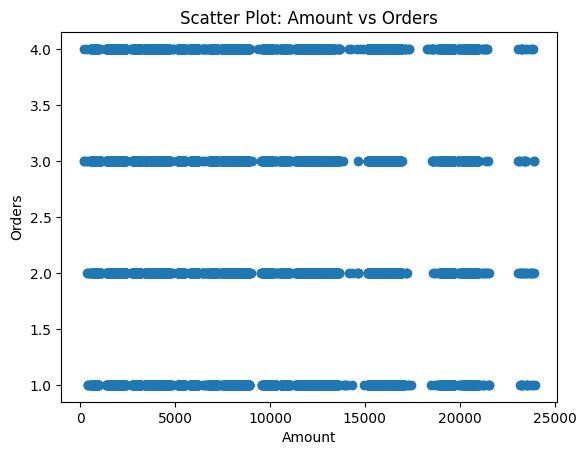

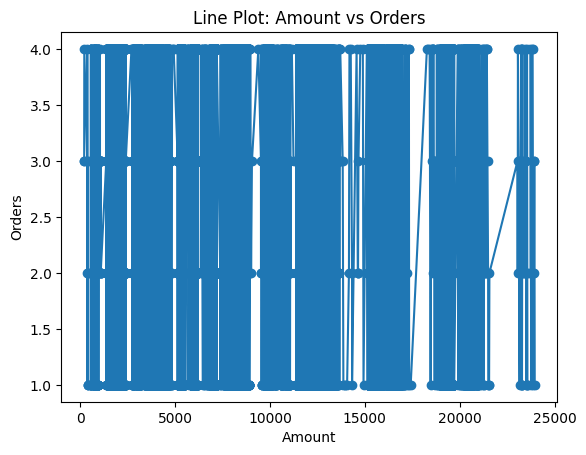

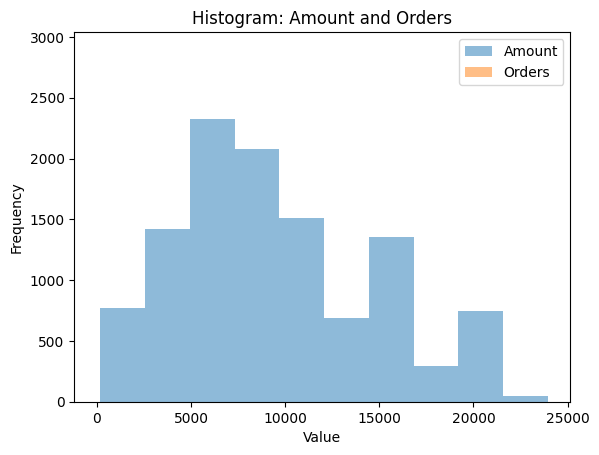

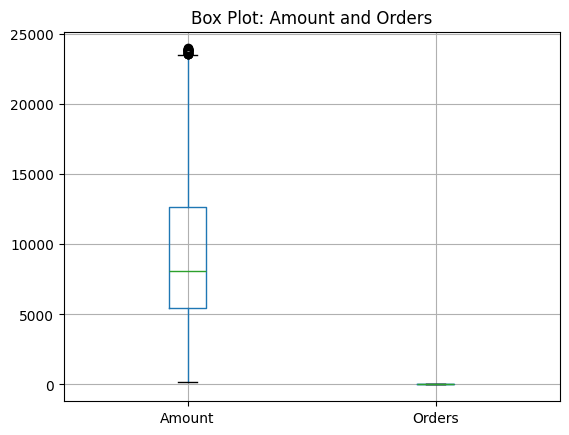

1. Analyze Two Numeric Columns
2. Analyze One Numeric and One String
3. Analyze One Numeric Column
4. Return
❌ Error: One or both columns '4' or 'Orders' not found in DataFrame.
1. Analyze Two Numeric Columns
2. Analyze One Numeric and One String
3. Analyze One Numeric Column
4. Return
Please Enter Valid Choice !
1. Analyze Two Numeric Columns
2. Analyze One Numeric and One String
3. Analyze One Numeric Column
4. Return
1. General Analysis
2. Custom Analysis
3. Return
Please Enter Valid Choice !
1. General Analysis
2. Custom Analysis
3. Return
Please Enter Valid Choice !
1. General Analysis
2. Custom Analysis
3. Return
Please Enter Valid Choice !
1. General Analysis
2. Custom Analysis
3. Return
Please Enter Valid Choice !
1. General Analysis
2. Custom Analysis
3. Return
Please Enter Valid Choice !
1. General Analysis
2. Custom Analysis
3. Return
Please Enter Valid Choice !
1. General Analysis
2. Custom Analysis
3. Return
Please Enter Valid Choice !
1. General Analysis
2. Custom Analysi

In [16]:
b=True
while(b):
    print("1. Analyze Data")
    print("2. Edit Data")
    print("3. Cleaning Data")
    print("4. Sort Folder")
    print("5. Exit")
    choice=input("Enter Choice: ")
    if(choice=="1"):
        Load_Data()
    elif(choice=="2"):
        print(2)
        pass
    elif(choice=="3"):
        print(3)
        pass
    elif(choice=="4"):
        print(4)
    elif(choice=="5"):
          print("Exiting Program...")
          b=False
    else:
        print("Please Enter Valid Choice !")
# C:\\Users\\Shivam\\Downloads\\Diwali Sales Data.csv
# C:\\Users\\Shivam\\Downloads\\road_accident_dataset.csv
# D:\\shivam
